In [2]:
%cd drive/My\ Drive/Colab\ Notebooks/DLG/semantic-mediawiki-page-creation/semantic-mediawiki-page-creation/sql-notebooks

/content/drive/My Drive/Colab Notebooks/DLG/semantic-mediawiki-page-creation/semantic-mediawiki-page-creation/sql-notebooks


In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from getpass import getpass
pjt_code = getpass('ProjectCode: ')

ProjectCode: ··········


# Question Talks Data

In [52]:
%%bigquery --project {pjt_code} df_question_talk_data
DECLARE start_date DATE DEFAULT "2019-01-01";
DECLARE end_date DATE DEFAULT "2020-12-31";
DECLARE channel_text STRING DEFAULT "03%質問%";
DECLARE ignore_text STRING DEFAULT "<%>さんがチャンネルに参加しました";


WITH 
-- [START] Create reply table
-- 1. get all talk data with filling the null thread_ts as ts
all_talks_with_filled_thread_ts AS (
  SELECT
    channel_id, ts AS thread_ts, ts, talk_user, talk_id
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    thread_ts IS NULL AND -- fill null thread_ts as ts
    talk_user IS NOT NULL -- exclude bot talks
  UNION ALL
  SELECT
    channel_id, thread_ts, ts, talk_user, talk_id
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    thread_ts IS NOT NULL AND -- if thread_ts is not null no replace
    talk_user IS NOT NULL -- exclude bot talks
),
all_talks_without_duplicated_talk_ids AS (
  SELECT
    a.channel_id, a.thread_ts, a.ts, a.talk_user, a.talk_id, r.target_date
  FROM
  (
    SELECT
      channel_id, thread_ts, ts, talk_user, MIN(talk_id) AS talk_id
    FROM
      all_talks_with_filled_thread_ts
    GROUP BY
      channel_id, thread_ts, ts, talk_user
  ) a
  LEFT JOIN
  (
    SELECT
      DISTINCT talk_id, target_date
    FROM
      mgm.talk
    WHERE
      target_date >= start_date AND target_date <= end_date
  ) r
  ON
    a.talk_id = r.talk_id
),
-- 2. get first talk ts in all threads
-- mainly first talk ts = thread_ts but it's not same in in some cases
first_talk_in_threads AS (
  SELECT
    channel_id, thread_ts, MIN(ts) AS ts -- get MIN(ts) because some first talk ts > thread_ts
  FROM
    all_talks_without_duplicated_talk_ids
  GROUP BY
    channel_id, thread_ts
  ORDER BY thread_ts
),
-- 3. join the talk_user, talk_id for first talks
thread_first_user_master AS (
  SELECT
    f.channel_id, f.thread_ts, f.ts, a.talk_user, a.talk_id, a.target_date
  FROM
    first_talk_in_threads f
      LEFT JOIN
        all_talks_without_duplicated_talk_ids a
      ON
        f.channel_id = a.channel_id AND f.thread_ts = a.thread_ts AND f.ts = a.ts
),
-- 4. get the reply talks (non first talks) on each threads
reply_talk_data AS (
  SELECT
    channel_id, thread_ts, ts, talk_user, talk_id, target_date
  FROM
    all_talks_without_duplicated_talk_ids AS raw
  WHERE
    talk_user IS NOT NULL AND
    NOT EXISTS(
      SELECT talk_id
      FROM thread_first_user_master AS mstr
      WHERE raw.talk_id = mstr.talk_id
    )
),
-- 5. join as reply table
reply_table AS (
  SELECT
    rp.channel_id,
    ROW_NUMBER() OVER(PARTITION BY rp.channel_id, rp.thread_ts ORDER BY rp.thread_ts, rp.ts, rp.channel_id) AS reply_num,
    rp.ts AS reply_ts, rp.talk_id AS reply_id, rp.talk_user AS reply_user,
    tm.thread_ts, tm.talk_id AS talk_id, tm.talk_user AS talk_user, rp.target_date
  FROM 
    reply_talk_data rp
      LEFT JOIN
        thread_first_user_master tm
      ON
        rp.channel_id = tm.channel_id AND rp.thread_ts = tm.thread_ts
  ORDER BY
    tm.thread_ts, rp.ts, rp.channel_id
),
-- [END] Create reply table
-- [START] Concat all talk data as reply table format
all_talk_data_in_reply_format AS (
  SELECT
    channel_id, 0 AS reply_num, ts AS reply_ts, talk_id AS reply_id,
    talk_user AS reply_user, thread_ts, talk_id AS talk_id, talk_user AS talk_user, target_date
  FROM
    thread_first_user_master
  UNION ALL
  SELECT
    *
  FROM
    reply_table
  ORDER BY thread_ts, reply_ts
),
-- [END] Concat all talk data as reply table format
-- [START] Create question channel master
question_channel_master AS (
  SELECT
    DISTINCT id AS channel_id, name AS channel_name, target_date
  FROM
    mgm.channel
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    name LIKE channel_text
),
-- [END] Create question channel master
-- [START] Create user name master
-- Get user name data for each target dates
user_names_with_date AS (
  SELECT
    user_id, real_name_normalized AS user_name, target_date
  FROM
    mgm.user
  WHERE
      target_date >= start_date AND target_date <= end_date AND
      display_name_normalized IS NULL -- use real name when display name is null
  UNION DISTINCT
  SELECT
    user_id, display_name_normalized AS user_name, target_date
  FROM
    mgm.user
  WHERE
      target_date >= start_date AND target_date <= end_date AND
      display_name_normalized IS NOT NULL -- use display name when not null
  ORDER BY target_date, user_id
),
-- Get the flag that each user are in the latest target date
user_in_current_table AS (
  SELECT
    user_id,
    MAX(target_date) = (SELECT MAX(target_date) FROM user_names_with_date) AS is_in_current
  FROM
    user_names_with_date
  GROUP BY
    user_id
),
-- Join the name & is in current flag
user_name_master AS (
  SELECT
    DISTINCT n.user_id, n.user_name, n.target_date, c.is_in_current
  FROM
    user_names_with_date n
  LEFT JOIN
    user_in_current_table c
  ON
    n.user_id = c.user_id
),
-- [END] Create user name master
-- [START] Get talk table with target date filtering
talk_table AS(
  SELECT
   DISTINCT talk_id, text
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    text NOT LIKE ignore_text
)
-- [END] Get talk table with target date filtering

SELECT
  q.channel_id, q.channel_name,
  a.reply_num, a.reply_ts, a.reply_id, a.reply_user, u.user_name AS reply_name,
  t.text AS reply_text, a.thread_ts, a.talk_user, a.target_date, 
  u.is_in_current AS reply_user_is_in_current
FROM
  all_talk_data_in_reply_format a
  INNER JOIN
    question_channel_master q
  ON
    a.channel_id = q.channel_id AND a.target_date = q.target_date
  LEFT JOIN
    user_name_master u
  ON a.reply_user = user_id AND a.target_date = u.target_date
  INNER JOIN
    talk_table t
  ON a.reply_id = t.talk_id
  ORDER BY channel_name, thread_ts, reply_ts
;

In [53]:
df_question_talk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996 entries, 0 to 3995
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   channel_id                3996 non-null   object             
 1   channel_name              3996 non-null   object             
 2   reply_num                 3996 non-null   int64              
 3   reply_ts                  3996 non-null   datetime64[ns, UTC]
 4   reply_id                  3996 non-null   object             
 5   reply_user                3996 non-null   object             
 6   reply_name                3996 non-null   object             
 7   reply_text                3996 non-null   object             
 8   thread_ts                 3996 non-null   datetime64[ns, UTC]
 9   talk_user                 3996 non-null   object             
 10  target_date               3996 non-null   object             
 11  reply_user_is_in_

In [54]:
df_question_talk_data['reply_ts'].value_counts()

2020-03-24 07:31:04.054000+00:00    1
2020-06-11 10:29:22.047300+00:00    1
2019-11-15 06:17:52.400600+00:00    1
2020-03-20 14:07:15.038900+00:00    1
2020-05-05 14:20:55.059700+00:00    1
                                   ..
2019-11-11 09:25:39.327000+00:00    1
2020-04-23 08:03:31.425600+00:00    1
2019-11-29 07:03:51.091500+00:00    1
2019-12-27 01:56:44.143300+00:00    1
2020-01-16 00:30:11.320200+00:00    1
Name: reply_ts, Length: 3996, dtype: int64

In [55]:
import pandas as pd
df_question_talk_data.to_csv('question_talk_data.csv', index=False)

In [56]:
!pip install japanize-matplotlib

In [57]:
import japanize_matplotlib

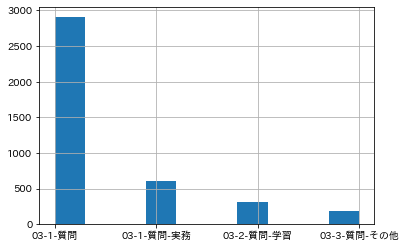

In [58]:
df_question_talk_data['channel_name'].hist()

In [59]:
df_question_talk_data['channel_name'].value_counts()

03-1-質問        2904
03-1-質問-実務      601
03-2-質問-学習      306
03-3-質問-その他     185
Name: channel_name, dtype: int64

# Introduction Talk Data
* Use the same query as question talks
* change the channel to '自己紹介'

In [60]:
%%bigquery --project {pjt_code} df_intro_talk_data
DECLARE start_date DATE DEFAULT "2019-01-01";
DECLARE end_date DATE DEFAULT "2020-12-31";
DECLARE channel_text STRING DEFAULT "01%自己紹介%";
DECLARE ignore_text STRING DEFAULT "<%>さんがチャンネルに参加しました";


WITH 
-- [START] Create reply table
-- 1. get all talk data with filling the null thread_ts as ts
all_talks_with_filled_thread_ts AS (
  SELECT
    channel_id, ts AS thread_ts, ts, talk_user, talk_id
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    thread_ts IS NULL AND -- fill null thread_ts as ts
    talk_user IS NOT NULL -- exclude bot talks
  UNION ALL
  SELECT
    channel_id, thread_ts, ts, talk_user, talk_id
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    thread_ts IS NOT NULL AND -- if thread_ts is not null no replace
    talk_user IS NOT NULL -- exclude bot talks
),
all_talks_without_duplicated_talk_ids AS (
  SELECT
    a.channel_id, a.thread_ts, a.ts, a.talk_user, a.talk_id, r.target_date
  FROM
  (
    SELECT
      channel_id, thread_ts, ts, talk_user, MIN(talk_id) AS talk_id
    FROM
      all_talks_with_filled_thread_ts
    GROUP BY
      channel_id, thread_ts, ts, talk_user
  ) a
  LEFT JOIN
  (
    SELECT
      DISTINCT talk_id, target_date
    FROM
      mgm.talk
    WHERE
      target_date >= start_date AND target_date <= end_date
  ) r
  ON
    a.talk_id = r.talk_id
),
-- 2. get first talk ts in all threads
-- mainly first talk ts = thread_ts but it's not same in in some cases
first_talk_in_threads AS (
  SELECT
    channel_id, thread_ts, MIN(ts) AS ts -- get MIN(ts) because some first talk ts > thread_ts
  FROM
    all_talks_without_duplicated_talk_ids
  GROUP BY
    channel_id, thread_ts
  ORDER BY thread_ts
),
-- 3. join the talk_user, talk_id for first talks
thread_first_user_master AS (
  SELECT
    f.channel_id, f.thread_ts, f.ts, a.talk_user, a.talk_id, a.target_date
  FROM
    first_talk_in_threads f
      LEFT JOIN
        all_talks_without_duplicated_talk_ids a
      ON
        f.channel_id = a.channel_id AND f.thread_ts = a.thread_ts AND f.ts = a.ts
),
-- 4. get the reply talks (non first talks) on each threads
reply_talk_data AS (
  SELECT
    channel_id, thread_ts, ts, talk_user, talk_id, target_date
  FROM
    all_talks_without_duplicated_talk_ids AS raw
  WHERE
    talk_user IS NOT NULL AND
    NOT EXISTS(
      SELECT talk_id
      FROM thread_first_user_master AS mstr
      WHERE raw.talk_id = mstr.talk_id
    )
),
-- 5. join as reply table
reply_table AS (
  SELECT
    rp.channel_id,
    ROW_NUMBER() OVER(PARTITION BY rp.channel_id, rp.thread_ts ORDER BY rp.thread_ts, rp.ts, rp.channel_id) AS reply_num,
    rp.ts AS reply_ts, rp.talk_id AS reply_id, rp.talk_user AS reply_user,
    tm.thread_ts, tm.talk_id AS talk_id, tm.talk_user AS talk_user, rp.target_date
  FROM 
    reply_talk_data rp
      LEFT JOIN
        thread_first_user_master tm
      ON
        rp.channel_id = tm.channel_id AND rp.thread_ts = tm.thread_ts
  ORDER BY
    tm.thread_ts, rp.ts, rp.channel_id
),
-- [END] Create reply table
-- [START] Concat all talk data as reply table format
all_talk_data_in_reply_format AS (
  SELECT
    channel_id, 0 AS reply_num, ts AS reply_ts, talk_id AS reply_id,
    talk_user AS reply_user, thread_ts, talk_id AS talk_id, talk_user AS talk_user, target_date
  FROM
    thread_first_user_master
  UNION ALL
  SELECT
    *
  FROM
    reply_table
  ORDER BY thread_ts, reply_ts
),
-- [END] Concat all talk data as reply table format
-- [START] Create question channel master
question_channel_master AS (
  SELECT
    DISTINCT id AS channel_id, name AS channel_name, target_date
  FROM
    mgm.channel
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    name LIKE channel_text
),
-- [END] Create question channel master
-- [START] Create user name master
-- Get user name data for each target dates
user_names_with_date AS (
  SELECT
    user_id, real_name_normalized AS user_name, target_date
  FROM
    mgm.user
  WHERE
      target_date >= start_date AND target_date <= end_date AND
      display_name_normalized IS NULL -- use real name when display name is null
  UNION DISTINCT
  SELECT
    user_id, display_name_normalized AS user_name, target_date
  FROM
    mgm.user
  WHERE
      target_date >= start_date AND target_date <= end_date AND
      display_name_normalized IS NOT NULL -- use display name when not null
  ORDER BY target_date, user_id
),
-- Get the flag that each user are in the latest target date
user_in_current_table AS (
  SELECT
    user_id,
    MAX(target_date) = (SELECT MAX(target_date) FROM user_names_with_date) AS is_in_current
  FROM
    user_names_with_date
  GROUP BY
    user_id
),
-- Join the name & is in current flag
user_name_master AS (
  SELECT
    DISTINCT n.user_id, n.user_name, n.target_date, c.is_in_current
  FROM
    user_names_with_date n
  LEFT JOIN
    user_in_current_table c
  ON
    n.user_id = c.user_id
),
-- [END] Create user name master
-- [START] Get talk table with target date filtering
talk_table AS(
  SELECT
   DISTINCT talk_id, text
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    text NOT LIKE ignore_text
)
-- [END] Get talk table with target date filtering

SELECT
  q.channel_id, q.channel_name,
  a.reply_num, a.reply_ts, a.reply_id, a.reply_user, u.user_name AS reply_name,
  t.text AS reply_text, a.thread_ts, a.talk_user, a.target_date, 
  u.is_in_current AS reply_user_is_in_current
FROM
  all_talk_data_in_reply_format a
  INNER JOIN
    question_channel_master q
  ON
    a.channel_id = q.channel_id AND a.target_date = q.target_date
  LEFT JOIN
    user_name_master u
  ON a.reply_user = user_id AND a.target_date = u.target_date
  INNER JOIN
    talk_table t
  ON a.reply_id = t.talk_id
  ORDER BY channel_name, thread_ts, reply_ts
;

In [61]:
df_intro_talk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   channel_id                1102 non-null   object             
 1   channel_name              1102 non-null   object             
 2   reply_num                 1102 non-null   int64              
 3   reply_ts                  1102 non-null   datetime64[ns, UTC]
 4   reply_id                  1102 non-null   object             
 5   reply_user                1102 non-null   object             
 6   reply_name                1102 non-null   object             
 7   reply_text                1102 non-null   object             
 8   thread_ts                 1102 non-null   datetime64[ns, UTC]
 9   talk_user                 1102 non-null   object             
 10  target_date               1102 non-null   object             
 11  reply_user_is_in_

In [62]:
df_intro_talk_data.to_csv('intro_talk_data.csv', index=False)

In [63]:
df_intro_talk_data['reply_ts'].value_counts()

2020-03-06 14:32:01.027300+00:00    1
2020-02-11 23:26:03.293900+00:00    1
2020-07-12 04:56:33.072400+00:00    1
2020-05-17 08:40:30.358700+00:00    1
2020-03-14 08:48:38.048800+00:00    1
                                   ..
2020-02-13 02:52:20.327100+00:00    1
2019-07-08 15:21:49.020600+00:00    1
2020-09-07 13:44:27.048800+00:00    1
2019-12-09 02:32:04.433900+00:00    1
2020-07-13 09:59:26.103000+00:00    1
Name: reply_ts, Length: 1102, dtype: int64